Instalación de las librerias a utilizar

In [ ]:
pip install scikeras

In [ ]:
pip install sktime

In [ ]:
pip install yfinance

Importacion de las distintas funciones

In [ ]:
from numpy.random import seed
import tensorflow as tf
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from keras.optimizers import SGD, RMSprop, Adadelta
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras import optimizers
from tensorflow.keras import Sequential
from tensorflow import keras
from keras.layers import (BatchNormalization, Dense, TimeDistributed, Bidirectional, LSTM, Dropout)
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

Construccion de funciones a utilizar y la clase Standardize

In [ ]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()


def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [ ]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split

    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val

    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s

    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s

    def inverse(self, data):
        return (data * self.sigma)+self.mu

    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [ ]:
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [ ]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=False,
                   input_shape=(train.shape[1],
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
#Optimizador Adam (valor default)

def train_model_ts_adam(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1),
              index=index).plot(style='k--', alpha=0.5, ax=ax[1],
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1),
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()

Carga de Base de datos

In [ ]:
BCol = pd.read_csv('/content/CIB.csv', index_col='Fecha', parse_dates=True)

BMA = pd.read_csv('/content/BMA.csv', index_col='Fecha', parse_dates=True)

Transformacion de la serie temporal univariable en una función en base a sus 5 rezagos

In [ ]:
BCol_os = one_step_forecast(BCol, 5)
BMA_os = one_step_forecast(BMA,5)

Estandarizacion de las dos bases de datos y division en set de trenamiento, test y validación.

In [ ]:
BCol_estand = Standardize(BCol_os)
BMA_estand = Standardize(BMA_os)

train_BCol, test_BCol, val_BCol = BCol_estand.fit_transform()
train_BMA, test_BMA, val_BMA = BMA_estand.fit_transform()

In [ ]:
print(f'''
BCol: Tamaño Entrenamiento: {len(train_BCol)}, Tamaño Validación: {len(val_BCol)}, Tamaño Test: {len(test_BCol)}
BMA: Tamaño Entrenamiento: {len(train_BMA)} , Tamaño Validación: {len(val_BMA)}, Tamaño Test: {len(test_BMA)}
''')


BCol: Tamaño Entrenamiento: 3469, Tamaño Validación: 385, Tamaño Test: 428
BMA: Tamaño Entrenamiento: 3469 , Tamaño Validación: 385, Tamaño Test: 428



Obtencion del set de entrenamiento, validacion y test para las variables independientes y dependiente respectivamente.

In [ ]:
(y_train_BCol,
 y_val_BCol,
 y_test_BCol,
 x_train_BCol,
 x_val_BCol,
 x_test_BCol) = features_target_ts(train_BCol, val_BCol,
                               test_BCol)

In [ ]:
(y_train_BMA,
 y_val_BMA,
 y_test_BMA,
 x_train_BMA,
 x_val_BMA,
 x_test_BMA) = features_target_ts(train_BMA,
                               val_BMA,
                               test_BMA)

In [ ]:
print(y_train_BCol.shape,
y_test_BCol.shape,
y_val_BCol.shape)

(3469, 1) (428, 1) (385, 1)


In [ ]:
print(x_train_BCol.shape,
x_test_BCol.shape,
x_val_BCol.shape)

(3469, 5, 1) (428, 5, 1) (385, 5, 1)


In [ ]:
print(y_train_BMA.shape,
y_test_BMA.shape,
y_val_BMA.shape)

(3469, 1) (428, 1) (385, 1)


In [ ]:
print(x_train_BMA.shape,
x_test_BMA.shape,
x_val_BMA.shape)

(3469, 5, 1) (428, 5, 1) (385, 5, 1)


Se implementa el LSTM con hiperparámetros con valor *Default*

In [ ]:
BCol_LSTM = create_model(train=x_train_BCol, units=32)
BCol_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
BMA_LSTM = create_model(train=x_train_BMA, units=32)
BMA_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
BCol_historial = train_model_ts_adam(BCol_LSTM, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 4s 15ms/step - loss: 0.6887 - root_mean_squared_error: 0.8299 - mean_absolute_percentage_error: 90.9241 - mean_absolute_error: 0.6300 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2048 - val_mean_absolute_percentage_error: 60.6131 - val_mean_absolute_error: 0.1316
Epoch 2/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0408 - root_mean_squared_error: 0.2020 - mean_absolute_percentage_error: 52.1283 - mean_absolute_error: 0.1548 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1919 - val_mean_absolute_percentage_error: 69.2976 - val_mean_absolute_error: 0.1305
Epoch 3/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0325 - root_mean_squared_error: 0.1804 - mean_absolute_percentage_error: 51.5228 - mean_absolute_error: 0.1382 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849 - val_mean_absolute_percentage_error: 65.9222 - val_mean_absolute_error: 0.1241
Epoch 4/500
109/109 [===

In [ ]:
BMA_historial = train_model_ts_adam(BMA_LSTM, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 4s 11ms/step - loss: 0.1500 - root_mean_squared_error: 0.3873 - mean_absolute_percentage_error: 126.9465 - mean_absolute_error: 0.2989 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1638 - val_mean_absolute_percentage_error: 23.1250 - val_mean_absolute_error: 0.1551
Epoch 2/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - mean_absolute_percentage_error: 52.1002 - mean_absolute_error: 0.1295 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498 - val_mean_absolute_percentage_error: 8.5106 - val_mean_absolute_error: 0.0375
Epoch 3/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0256 - root_mean_squared_error: 0.1601 - mean_absolute_percentage_error: 49.6741 - mean_absolute_error: 0.1092 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763 - val_mean_absolute_percentage_error: 11.8453 - val_mean_absolute_error: 0.0670
Epoch 4/500
109/109 [===

14/14 [==============================] - 0s 2ms/step


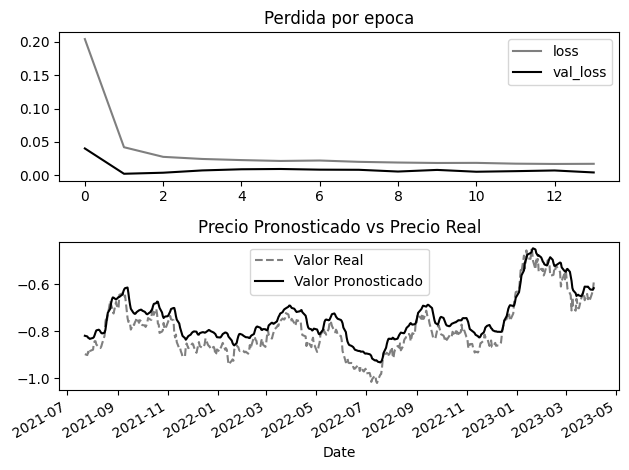

In [ ]:
plot_forecast(BMA_LSTM, x_test_BMA, y_test_BMA, test_BMA.index, BMA_historial)

14/14 [==============================] - 1s 3ms/step


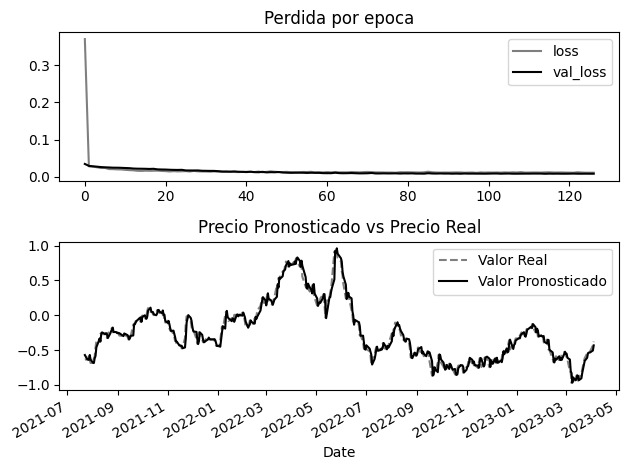

In [ ]:
plot_forecast(BCol_LSTM, x_test_BCol, y_test_BCol, test_BCol.index, BCol_historial)

Implementacion de LSTM con dos capas ocultas

In [ ]:
def create_model_2capas(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
BCol_LSTM_2cap = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
BMA_LSTM_2cap = create_model_2capas(train=x_train_BMA, units=32)

In [ ]:
BCol_historial_2cap = train_model_ts_adam(BCol_LSTM_2cap, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 8s 24ms/step - loss: 0.2637 - root_mean_squared_error: 0.5135 - mean_absolute_percentage_error: 83.9659 - mean_absolute_error: 0.3854 - val_loss: 0.0572 - val_root_mean_squared_error: 0.2391 - val_mean_absolute_percentage_error: 89.8636 - val_mean_absolute_error: 0.1891
Epoch 2/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0359 - root_mean_squared_error: 0.1895 - mean_absolute_percentage_error: 53.4681 - mean_absolute_error: 0.1461 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1810 - val_mean_absolute_percentage_error: 65.8069 - val_mean_absolute_error: 0.1203
Epoch 3/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770 - mean_absolute_percentage_error: 46.3041 - mean_absolute_error: 0.1347 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1835 - val_mean_absolute_percentage_error: 69.0622 - val_mean_absolute_error: 0.1228
Epoch 4/500
109/109 [===

In [ ]:
BMA_historial_2cap = train_model_ts_adam(BMA_LSTM_2cap, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 8s 19ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567 - mean_absolute_percentage_error: 181.9333 - mean_absolute_error: 0.3655 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350 - val_mean_absolute_percentage_error: 20.0530 - val_mean_absolute_error: 0.1264
Epoch 2/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0782 - root_mean_squared_error: 0.2796 - mean_absolute_percentage_error: 82.7823 - mean_absolute_error: 0.1750 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467 - val_mean_absolute_percentage_error: 22.9206 - val_mean_absolute_error: 0.1387
Epoch 3/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - mean_absolute_percentage_error: 74.1852 - mean_absolute_error: 0.1391 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595 - val_mean_absolute_percentage_error: 10.1956 - val_mean_absolute_error: 0.0429
Epoch 4/500
109/109 [==

Tres capas ocultas

In [ ]:
def create_model_3capas(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
BCol_LSTM_3cap = create_model_3capas(train=x_train_BCol, units=32)

BMA_LSTM_3cap = create_model_3capas(train=x_train_BMA, units=32)

In [ ]:
BCol_historial_3cap = train_model_ts_adam(BCol_LSTM_3cap, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 9s 28ms/step - loss: 0.3681 - root_mean_squared_error: 0.6067 - mean_absolute_percentage_error: 103.0139 - mean_absolute_error: 0.4609 - val_loss: 0.0781 - val_root_mean_squared_error: 0.2794 - val_mean_absolute_percentage_error: 105.5768 - val_mean_absolute_error: 0.2292
Epoch 2/500
109/109 [==============================] - 2s 17ms/step - loss: 0.0471 - root_mean_squared_error: 0.2170 - mean_absolute_percentage_error: 60.8686 - mean_absolute_error: 0.1675 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955 - val_mean_absolute_percentage_error: 72.7592 - val_mean_absolute_error: 0.1284
Epoch 3/500
109/109 [==============================] - 2s 15ms/step - loss: 0.0396 - root_mean_squared_error: 0.1989 - mean_absolute_percentage_error: 49.4498 - mean_absolute_error: 0.1531 - val_loss: 0.0470 - val_root_mean_squared_error: 0.2169 - val_mean_absolute_percentage_error: 82.9265 - val_mean_absolute_error: 0.1545
Epoch 4/500
109/109 

In [ ]:
BMA_historial_3cap = train_model_ts_adam(BMA_LSTM_3cap, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 9s 27ms/step - loss: 0.3070 - root_mean_squared_error: 0.5540 - mean_absolute_percentage_error: 268.2053 - mean_absolute_error: 0.4572 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400 - val_mean_absolute_percentage_error: 20.0555 - val_mean_absolute_error: 0.1301
Epoch 2/500
109/109 [==============================] - 2s 18ms/step - loss: 0.1502 - root_mean_squared_error: 0.3875 - mean_absolute_percentage_error: 112.4292 - mean_absolute_error: 0.2467 - val_loss: 0.0777 - val_root_mean_squared_error: 0.2788 - val_mean_absolute_percentage_error: 40.8548 - val_mean_absolute_error: 0.2680
Epoch 3/500
109/109 [==============================] - 2s 17ms/step - loss: 0.0741 - root_mean_squared_error: 0.2721 - mean_absolute_percentage_error: 92.7976 - mean_absolute_error: 0.1786 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787 - val_mean_absolute_percentage_error: 13.9703 - val_mean_absolute_error: 0.0635
Epoch 4/500
109/109 

LSTM con 5 capas ocultas

In [ ]:
def create_model_5capas(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
BCol_LSTM_5cap = create_model_5capas(train=x_train_BCol, units=32)

BMA_LSTM_5cap = create_model_5capas(train=x_train_BMA, units=32)

In [ ]:
BCol_historial_5cap = train_model_ts_adam(BCol_LSTM_5cap, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 22s 39ms/step - loss: 0.7022 - root_mean_squared_error: 0.8380 - mean_absolute_percentage_error: 156.1385 - mean_absolute_error: 0.6840 - val_loss: 0.0962 - val_root_mean_squared_error: 0.3102 - val_mean_absolute_percentage_error: 120.1106 - val_mean_absolute_error: 0.2571
Epoch 2/500
109/109 [==============================] - 6s 55ms/step - loss: 0.0658 - root_mean_squared_error: 0.2564 - mean_absolute_percentage_error: 72.5639 - mean_absolute_error: 0.1951 - val_loss: 0.0531 - val_root_mean_squared_error: 0.2305 - val_mean_absolute_percentage_error: 91.6581 - val_mean_absolute_error: 0.1547
Epoch 3/500
109/109 [==============================] - 4s 35ms/step - loss: 0.0862 - root_mean_squared_error: 0.2935 - mean_absolute_percentage_error: 70.4126 - mean_absolute_error: 0.2253 - val_loss: 0.0770 - val_root_mean_squared_error: 0.2775 - val_mean_absolute_percentage_error: 105.0588 - val_mean_absolute_error: 0.2173
Epoch 4/500
109/10

In [ ]:
BMA_historial_5cap = train_model_ts_adam(BMA_LSTM_5cap, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 17s 40ms/step - loss: 0.6961 - root_mean_squared_error: 0.8343 - mean_absolute_percentage_error: 333.8477 - mean_absolute_error: 0.6793 - val_loss: 0.2298 - val_root_mean_squared_error: 0.4794 - val_mean_absolute_percentage_error: 74.7777 - val_mean_absolute_error: 0.4721
Epoch 2/500
109/109 [==============================] - 2s 19ms/step - loss: 0.1585 - root_mean_squared_error: 0.3981 - mean_absolute_percentage_error: 145.7916 - mean_absolute_error: 0.2813 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025 - val_mean_absolute_percentage_error: 22.2985 - val_mean_absolute_error: 0.0834
Epoch 3/500
109/109 [==============================] - 3s 29ms/step - loss: 0.1318 - root_mean_squared_error: 0.3631 - mean_absolute_percentage_error: 200.5114 - mean_absolute_error: 0.2725 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297 - val_mean_absolute_percentage_error: 20.9759 - val_mean_absolute_error: 0.1169
Epoch 4/500
109/10

In [ ]:
#BCol

Metricas_Error_BCol = pd.DataFrame(np.array([BCol_LSTM.evaluate(x=x_test_BCol, y=y_test_BCol),
   BCol_LSTM_2cap.evaluate(x=x_test_BCol, y=y_test_BCol), BCol_LSTM_3cap.evaluate(x=x_test_BCol, y=y_test_BCol),
                              BCol_LSTM_5cap.evaluate(x=x_test_BCol, y=y_test_BCol)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BCol. LSTM Una capa oculta', 'BCol. LSTM Dos capas ocultas',
                             'BCol. LSTM Tres capas ocultas', 'BCol. LSTM Cinco capas ocultas'])

14/14 [==============================] - 0s 8ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - mean_absolute_percentage_error: 183.8455 - mean_absolute_error: 0.1121


In [ ]:
Metricas_Error_BCol.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

,RMSE,MAPE,MAE
BCol. LSTM Dos capas ocultas,0.066810,84.406349,0.050627
BCol. LSTM Una capa oculta,0.067276,84.707359,0.050597
BCol. LSTM Tres capas ocultas,0.097932,181.803085,0.081001
BCol. LSTM Cinco capas ocultas,0.147078,183.845520,0.112117


In [ ]:
#BMA

Metricas_Error_BMA = pd.DataFrame(np.array([BMA_LSTM.evaluate(x=x_test_BMA, y=y_test_BMA),
   BMA_LSTM_2cap.evaluate(x=x_test_BMA, y=y_test_BMA), BMA_LSTM_3cap.evaluate(x=x_test_BMA, y=y_test_BMA),
                              BMA_LSTM_5cap.evaluate(x=x_test_BMA, y=y_test_BMA)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BMA. LSTM Una capa oculta', 'BMA. LSTM Dos capas ocultas',
                             'BMA. LSTM Tres capas ocultas', 'BMA. LSTM Cinco capas ocultas'])

14/14 [==============================] - 0s 6ms/step - loss: 0.0343 - root_mean_squared_error: 0.1852 - mean_absolute_percentage_error: 22.4117 - mean_absolute_error: 0.1792


In [ ]:
Metricas_Error_BMA.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

,RMSE,MAPE,MAE
BMA. LSTM Una capa oculta,0.027008,2.771262,0.020851
BMA. LSTM Tres capas ocultas,0.050934,5.419922,0.042688
BMA. LSTM Dos capas ocultas,0.066348,7.811426,0.062028
BMA. LSTM Cinco capas ocultas,0.185169,22.411730,0.179174


Identificacion del mejor algoritmo optimizador

In [ ]:
def train_model_ts_adam(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BMA_LSTM_adam = create_model(train=x_train_BMA, units=32)

BCol_LSTM_adam = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
BCol_adam_historial = train_model_ts_adam(BCol_LSTM_adam, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 7s 22ms/step - loss: 0.4066 - root_mean_squared_error: 0.6376 - mean_absolute_percentage_error: 84.9333 - mean_absolute_error: 0.4636 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2047 - val_mean_absolute_percentage_error: 69.4312 - val_mean_absolute_error: 0.1451
Epoch 2/500
109/109 [==============================] - 1s 10ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968 - mean_absolute_percentage_error: 52.8351 - mean_absolute_error: 0.1478 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1809 - val_mean_absolute_percentage_error: 64.7043 - val_mean_absolute_error: 0.1186
Epoch 3/500
109/109 [==============================] - 1s 10ms/step - loss: 0.0330 - root_mean_squared_error: 0.1818 - mean_absolute_percentage_error: 48.3284 - mean_absolute_error: 0.1385 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1814 - val_mean_absolute_percentage_error: 65.8292 - val_mean_absolute_error: 0.1194
Epoch 4/500
109/109 [=

In [ ]:
BMA_adam_historial = train_model_ts_adam(BMA_LSTM_adam, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 4s 11ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628 - mean_absolute_percentage_error: 147.6841 - mean_absolute_error: 0.3606 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181 - val_mean_absolute_percentage_error: 30.5108 - val_mean_absolute_error: 0.2081
Epoch 2/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0399 - root_mean_squared_error: 0.1999 - mean_absolute_percentage_error: 59.8291 - mean_absolute_error: 0.1382 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 8.6901 - val_mean_absolute_error: 0.0365
Epoch 3/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - mean_absolute_percentage_error: 51.9413 - mean_absolute_error: 0.1142 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641 - val_mean_absolute_percentage_error: 10.5903 - val_mean_absolute_error: 0.0544
Epoch 4/500
109/109 [===

In [ ]:
#Optimizador Stochastic Gradient Descent

sgd = SGD(learning_rate=0.1, momentum=0.2)

def train_model_ts_sgd(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer=sgd,
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BCol_LSTM_sgd = create_model_2capas(train=x_train_BCol, units=32)

BMA_LSTM_sgd = create_model(train=x_train_BMA, units=32)

In [ ]:
BCol_sgd_historial = train_model_ts_sgd(BCol_LSTM_sgd, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 6s 17ms/step - loss: 0.1062 - root_mean_squared_error: 0.3259 - mean_absolute_percentage_error: 117.1034 - mean_absolute_error: 0.2430 - val_loss: 0.8056 - val_root_mean_squared_error: 0.8976 - val_mean_absolute_percentage_error: 490.8765 - val_mean_absolute_error: 0.8532
Epoch 2/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - mean_absolute_percentage_error: 43.6049 - mean_absolute_error: 0.1414 - val_loss: 0.0998 - val_root_mean_squared_error: 0.3159 - val_mean_absolute_percentage_error: 175.8318 - val_mean_absolute_error: 0.2690
Epoch 3/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0286 - root_mean_squared_error: 0.1692 - mean_absolute_percentage_error: 45.3228 - mean_absolute_error: 0.1247 - val_loss: 0.0689 - val_root_mean_squared_error: 0.2625 - val_mean_absolute_percentage_error: 131.9451 - val_mean_absolute_error: 0.2110
Epoch 4/500
109/109 

In [ ]:

def train_model_ts_sgd(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='SGD',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BMA_sgd_historial = train_model_ts_sgd(BMA_LSTM_sgd, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 4s 11ms/step - loss: 0.2475 - root_mean_squared_error: 0.4975 - mean_absolute_percentage_error: 256.9493 - mean_absolute_error: 0.4167 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2893 - val_mean_absolute_percentage_error: 45.0858 - val_mean_absolute_error: 0.2844
Epoch 2/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0358 - root_mean_squared_error: 0.1892 - mean_absolute_percentage_error: 47.2654 - mean_absolute_error: 0.1278 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443 - val_mean_absolute_percentage_error: 6.8708 - val_mean_absolute_error: 0.0308
Epoch 3/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - mean_absolute_percentage_error: 43.0063 - mean_absolute_error: 0.1079 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466 - val_mean_absolute_percentage_error: 7.5805 - val_mean_absolute_error: 0.0326
Epoch 4/500
109/109 [====

In [ ]:
#Optimizador RMSprop

def train_model_ts_rmsprop(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='RMSprop',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history


In [ ]:
BMA_LSTM_rmsprop = create_model(train=x_train_BMA, units=32)

BCol_LSTM_rmsprop = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
BCol_rmsprop_historial = train_model_ts_rmsprop(BCol_LSTM_rmsprop, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 7s 19ms/step - loss: 0.1732 - root_mean_squared_error: 0.4162 - mean_absolute_percentage_error: 62.9871 - mean_absolute_error: 0.2614 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2183 - val_mean_absolute_percentage_error: 92.0844 - val_mean_absolute_error: 0.1478
Epoch 2/500
109/109 [==============================] - 1s 14ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514 - mean_absolute_percentage_error: 43.4707 - mean_absolute_error: 0.1167 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204 - val_mean_absolute_percentage_error: 92.4184 - val_mean_absolute_error: 0.1456
Epoch 3/500
109/109 [==============================] - 1s 13ms/step - loss: 0.0224 - root_mean_squared_error: 0.1498 - mean_absolute_percentage_error: 44.8335 - mean_absolute_error: 0.1153 - val_loss: 0.0439 - val_root_mean_squared_error: 0.2095 - val_mean_absolute_percentage_error: 86.1449 - val_mean_absolute_error: 0.1369
Epoch 4/500
109/109 [=

In [ ]:
BMA_rmsprop_historial = train_model_ts_rmsprop(BMA_LSTM_rmsprop, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 4s 12ms/step - loss: 0.0537 - root_mean_squared_error: 0.2316 - mean_absolute_percentage_error: 84.1465 - mean_absolute_error: 0.1655 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 7.7587 - val_mean_absolute_error: 0.0375
Epoch 2/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0219 - root_mean_squared_error: 0.1480 - mean_absolute_percentage_error: 43.0109 - mean_absolute_error: 0.0998 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684 - val_mean_absolute_percentage_error: 9.7967 - val_mean_absolute_error: 0.0585
Epoch 3/500
109/109 [==============================] - 1s 7ms/step - loss: 0.0201 - root_mean_squared_error: 0.1418 - mean_absolute_percentage_error: 40.6770 - mean_absolute_error: 0.0935 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - val_mean_absolute_percentage_error: 11.1920 - val_mean_absolute_error: 0.0712
Epoch 4/500
109/109 [=====

In [ ]:
#Optimizador Adagrad

def train_model_ts_Adagrad(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='Adagrad',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:

def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=False,
                   input_shape=(train.shape[1],
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
def create_model_2capas(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
BMA_LSTM_Adagrad = create_model(train=x_train_BMA, units=32)

BCol_LSTM_Adagrad = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
BCol_Adagrad_historial = train_model_ts_Adagrad(BCol_LSTM_Adagrad, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 7s 28ms/step - loss: 0.9490 - root_mean_squared_error: 0.9742 - mean_absolute_percentage_error: 101.6003 - mean_absolute_error: 0.8397 - val_loss: 0.4864 - val_root_mean_squared_error: 0.6974 - val_mean_absolute_percentage_error: 98.7103 - val_mean_absolute_error: 0.6012
Epoch 2/500
109/109 [==============================] - 1s 13ms/step - loss: 0.8062 - root_mean_squared_error: 0.8979 - mean_absolute_percentage_error: 93.9817 - mean_absolute_error: 0.7733 - val_loss: 0.4185 - val_root_mean_squared_error: 0.6469 - val_mean_absolute_percentage_error: 93.7178 - val_mean_absolute_error: 0.5568
Epoch 3/500
109/109 [==============================] - 1s 9ms/step - loss: 0.6967 - root_mean_squared_error: 0.8347 - mean_absolute_percentage_error: 88.1056 - mean_absolute_error: 0.7174 - val_loss: 0.3612 - val_root_mean_squared_error: 0.6010 - val_mean_absolute_percentage_error: 89.2310 - val_mean_absolute_error: 0.5165
Epoch 4/500
109/109 [=

In [ ]:
BMA_Adagrad_historial = train_model_ts_Adagrad(BMA_LSTM_Adagrad, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 3s 12ms/step - loss: 0.7310 - root_mean_squared_error: 0.8550 - mean_absolute_percentage_error: 103.5785 - mean_absolute_error: 0.6752 - val_loss: 0.3136 - val_root_mean_squared_error: 0.5600 - val_mean_absolute_percentage_error: 71.7726 - val_mean_absolute_error: 0.5355
Epoch 2/500
109/109 [==============================] - 1s 6ms/step - loss: 0.5890 - root_mean_squared_error: 0.7675 - mean_absolute_percentage_error: 93.6804 - mean_absolute_error: 0.5930 - val_loss: 0.2547 - val_root_mean_squared_error: 0.5046 - val_mean_absolute_percentage_error: 64.3648 - val_mean_absolute_error: 0.4819
Epoch 3/500
109/109 [==============================] - 1s 6ms/step - loss: 0.5123 - root_mean_squared_error: 0.7157 - mean_absolute_percentage_error: 87.0809 - mean_absolute_error: 0.5456 - val_loss: 0.2129 - val_root_mean_squared_error: 0.4615 - val_mean_absolute_percentage_error: 58.6606 - val_mean_absolute_error: 0.4400
Epoch 4/500
109/109 [==

In [ ]:
Metricas_Error_BCol = pd.DataFrame(np.array([BCol_LSTM_adam.evaluate(x=x_test_BCol, y=y_test_BCol),
   BCol_LSTM_sgd.evaluate(x=x_test_BCol, y=y_test_BCol), BCol_LSTM_rmsprop.evaluate(x=x_test_BCol, y=y_test_BCol),
                              BCol_LSTM_Adagrad.evaluate(x=x_test_BCol, y=y_test_BCol)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BCol. Optimizador Adam', 'BCol. Optimizador SGD',
                             'BCol. Optimizador RMSprop', 'BCol. Optimizador Adagrad'])

Metricas_Error_BCol.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 6ms/step - loss: 0.0241 - root_mean_squared_error: 0.1552 - mean_absolute_percentage_error: 209.4388 - mean_absolute_error: 0.1212


,RMSE,MAPE,MAE
BCol. Optimizador Adam,0.069329,92.751305,0.052639
BCol. Optimizador RMSprop,0.076333,135.089859,0.058344
BCol. Optimizador Adagrad,0.155179,209.438782,0.121238
BCol. Optimizador SGD,0.179886,340.239288,0.155228


In [ ]:
Metricas_Error_BMA = pd.DataFrame(np.array([BMA_LSTM_adam.evaluate(x=x_test_BMA, y=y_test_BMA),
    BMA_LSTM_rmsprop.evaluate(x=x_test_BMA, y=y_test_BMA),  BMA_LSTM_sgd.evaluate(x=x_test_BMA, y=y_test_BMA),
                                            BMA_LSTM_Adagrad.evaluate(x=x_test_BMA, y=y_test_BMA)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BMA. Optimizador Adam', 'BMA. Optimizador RMSprop', 'BMA. Optimizador SGD','BMA. Optimizador Adagrad'])

Metricas_Error_BMA.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 4.4661 - mean_absolute_error: 0.0336


,RMSE,MAPE,MAE
BMA. Optimizador Adam,0.040267,4.369713,0.033564
BMA. Optimizador Adagrad,0.042225,4.466066,0.033552
BMA. Optimizador SGD,0.044946,4.702649,0.037774
BMA. Optimizador RMSprop,0.064034,7.235543,0.058211


Busqueda del tamaño optimo del Batch.

In [ ]:
#Optimizador Adam con batch size de 16

def train_model_ts_BColbatch16(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=16):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BCol_LSTM_batch16 = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
BCol_batch16_historial = train_model_ts_BColbatch16(BCol_LSTM_batch16, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
217/217 [==============================] - 8s 18ms/step - loss: 0.0954 - root_mean_squared_error: 0.3089 - mean_absolute_percentage_error: 55.0086 - mean_absolute_error: 0.1850 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2107 - val_mean_absolute_percentage_error: 93.6678 - val_mean_absolute_error: 0.1390
Epoch 2/500
217/217 [==============================] - 2s 10ms/step - loss: 0.0201 - root_mean_squared_error: 0.1416 - mean_absolute_percentage_error: 43.1838 - mean_absolute_error: 0.1094 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2122 - val_mean_absolute_percentage_error: 93.8362 - val_mean_absolute_error: 0.1429
Epoch 3/500
217/217 [==============================] - 2s 8ms/step - loss: 0.0190 - root_mean_squared_error: 0.1379 - mean_absolute_percentage_error: 42.5035 - mean_absolute_error: 0.1059 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040 - val_mean_absolute_percentage_error: 82.3775 - val_mean_absolute_error: 0.1452
Epoch 4/500
217/217 [==

In [ ]:
#BMA

def train_model_ts_BMAbatch16(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=16):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BMA_LSTM_batch16 = create_model(train=x_train_BMA, units=32)

In [ ]:
BMA_batch16_historial = train_model_ts_BMAbatch16(BMA_LSTM_batch16, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
217/217 [==============================] - 8s 18ms/step - loss: 0.0761 - root_mean_squared_error: 0.2758 - mean_absolute_percentage_error: 103.6892 - mean_absolute_error: 0.2049 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540 - val_mean_absolute_percentage_error: 20.8151 - val_mean_absolute_error: 0.1449
Epoch 2/500
217/217 [==============================] - 2s 9ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819 - mean_absolute_percentage_error: 45.1786 - mean_absolute_error: 0.1132 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - val_mean_absolute_percentage_error: 11.3380 - val_mean_absolute_error: 0.0720
Epoch 3/500
217/217 [==============================] - 1s 5ms/step - loss: 0.0396 - root_mean_squared_error: 0.1991 - mean_absolute_percentage_error: 46.8272 - mean_absolute_error: 0.1173 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592 - val_mean_absolute_percentage_error: 8.6459 - val_mean_absolute_error: 0.0487
Epoch 4/500
217/217 [===

In [ ]:
#BCol con bath size de 64 unidades

def train_model_ts_BColbatch64(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=64):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BCol_LSTM_batch64 = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
BCol_batch64_historial = train_model_ts_BColbatch64(BCol_LSTM_batch64, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
55/55 [==============================] - 6s 27ms/step - loss: 0.3019 - root_mean_squared_error: 0.5494 - mean_absolute_percentage_error: 73.5168 - mean_absolute_error: 0.3925 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2086 - val_mean_absolute_percentage_error: 82.0520 - val_mean_absolute_error: 0.1410
Epoch 2/500
55/55 [==============================] - 0s 9ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580 - mean_absolute_percentage_error: 44.3422 - mean_absolute_error: 0.1210 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2078 - val_mean_absolute_percentage_error: 83.9374 - val_mean_absolute_error: 0.1360
Epoch 3/500
55/55 [==============================] - 1s 10ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - mean_absolute_percentage_error: 44.5038 - mean_absolute_error: 0.1205 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2004 - val_mean_absolute_percentage_error: 78.7628 - val_mean_absolute_error: 0.1297
Epoch 4/500
55/55 [==========

In [ ]:
#BMA con batch size de 64 unidades

def train_model_ts_BMAbatch64(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=64):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BMA_LSTM_batch64 = create_model(train=x_train_BMA, units=32)

In [ ]:
BMA_batch64_historial = train_model_ts_BMAbatch64(BMA_LSTM_batch64, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
55/55 [==============================] - 4s 37ms/step - loss: 0.7607 - root_mean_squared_error: 0.8722 - mean_absolute_percentage_error: 141.5378 - mean_absolute_error: 0.6875 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855 - val_mean_absolute_percentage_error: 25.3822 - val_mean_absolute_error: 0.1733
Epoch 2/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1525 - root_mean_squared_error: 0.3905 - mean_absolute_percentage_error: 77.0468 - mean_absolute_error: 0.2277 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777 - val_mean_absolute_percentage_error: 12.2175 - val_mean_absolute_error: 0.0649
Epoch 3/500
55/55 [==============================] - 0s 6ms/step - loss: 0.0581 - root_mean_squared_error: 0.2410 - mean_absolute_percentage_error: 61.5679 - mean_absolute_error: 0.1551 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 8.1027 - val_mean_absolute_error: 0.0383
Epoch 4/500
55/55 [===========

In [ ]:
Metricas_Error_BCol = pd.DataFrame(np.array([BCol_LSTM_batch16.evaluate(x=x_test_BCol, y=y_test_BCol),
   BCol_LSTM_batch64.evaluate(x=x_test_BCol, y=y_test_BCol), BCol_LSTM_adam.evaluate(x=x_test_BCol, y=y_test_BCol)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BCol. Tamaño Batch 16', 'BCol. Tamaño Batch 64', 'BCol. Tamaño Batch 32'])

Metricas_Error_BCol.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 4ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - mean_absolute_percentage_error: 123.7189 - mean_absolute_error: 0.0552


,RMSE,MAPE,MAE
BCol. Tamaño Batch 32,0.072059,123.718918,0.055249
BCol. Tamaño Batch 64,0.072809,92.683426,0.055507
BCol. Tamaño Batch 16,0.074175,126.845627,0.057565


In [ ]:
Metricas_Error_BMA = pd.DataFrame(np.array([BMA_LSTM_adam.evaluate(x=x_test_BMA, y=y_test_BMA),
    BMA_LSTM_batch16.evaluate(x=x_test_BMA, y=y_test_BMA), BMA_LSTM_batch64.evaluate(x=x_test_BMA, y=y_test_BMA)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BMA. Tamaño Batch 32', 'BMA. Tamaño Batch 16', 'BMA. Tamaño Batch 64'])

Metricas_Error_BMA.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 6ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - mean_absolute_percentage_error: 6.7557 - mean_absolute_error: 0.0551


,RMSE,MAPE,MAE
BMA. Tamaño Batch 32,0.029975,3.084904,0.023285
BMA. Tamaño Batch 16,0.039240,4.201008,0.032778
BMA. Tamaño Batch 64,0.063411,6.755686,0.055093


Identificación del numero optimo de neuronas en capa oculta

In [ ]:
def train_model_ts_adam(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BCol_LSTM_neur20 = create_model_2capas(train=x_train_BCol, units=20)

BMA_LSTM_neur20 = create_model(train=x_train_BMA, units=20)

In [ ]:
BCol_neur20_historial = train_model_ts_adam(BCol_LSTM_neur20, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
217/217 [==============================] - 7s 13ms/step - loss: 0.1803 - root_mean_squared_error: 0.4246 - mean_absolute_percentage_error: 66.0698 - mean_absolute_error: 0.2684 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2158 - val_mean_absolute_percentage_error: 98.7614 - val_mean_absolute_error: 0.1384
Epoch 2/500
217/217 [==============================] - 3s 12ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699 - mean_absolute_percentage_error: 47.4267 - mean_absolute_error: 0.1277 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2068 - val_mean_absolute_percentage_error: 86.5420 - val_mean_absolute_error: 0.1356
Epoch 3/500
217/217 [==============================] - 5s 21ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637 - mean_absolute_percentage_error: 44.4813 - mean_absolute_error: 0.1229 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2025 - val_mean_absolute_percentage_error: 84.4472 - val_mean_absolute_error: 0.1343
Epoch 4/500
217/217 [=

In [ ]:
BMA_neur20_historial = train_model_ts_adam(BMA_LSTM_neur20, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 5s 16ms/step - loss: 0.2376 - root_mean_squared_error: 0.4874 - mean_absolute_percentage_error: 128.8372 - mean_absolute_error: 0.3477 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1720 - val_mean_absolute_percentage_error: 23.7925 - val_mean_absolute_error: 0.1630
Epoch 2/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0610 - root_mean_squared_error: 0.2469 - mean_absolute_percentage_error: 85.7393 - mean_absolute_error: 0.1716 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 8.5260 - val_mean_absolute_error: 0.0428
Epoch 3/500
109/109 [==============================] - 1s 8ms/step - loss: 0.0398 - root_mean_squared_error: 0.1996 - mean_absolute_percentage_error: 46.3740 - mean_absolute_error: 0.1291 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 8.1285 - val_mean_absolute_error: 0.0373
Epoch 4/500
109/109 [====

In [ ]:
BCol_LSTM_neur70 = create_model_2capas(train=x_train_BCol, units=70)

BMA_LSTM_neur70 = create_model(train=x_train_BMA, units=70)

In [ ]:
BCol_neur70_historial = train_model_ts_adam(BCol_LSTM_neur70, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
217/217 [==============================] - 8s 16ms/step - loss: 0.0465 - root_mean_squared_error: 0.2157 - mean_absolute_percentage_error: 48.9917 - mean_absolute_error: 0.1327 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2248 - val_mean_absolute_percentage_error: 111.1664 - val_mean_absolute_error: 0.1558
Epoch 2/500
217/217 [==============================] - 6s 29ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - mean_absolute_percentage_error: 42.4246 - mean_absolute_error: 0.1055 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2070 - val_mean_absolute_percentage_error: 96.8619 - val_mean_absolute_error: 0.1442
Epoch 3/500
217/217 [==============================] - 4s 19ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - mean_absolute_percentage_error: 40.3759 - mean_absolute_error: 0.1000 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1880 - val_mean_absolute_percentage_error: 79.7405 - val_mean_absolute_error: 0.1293
Epoch 4/500
217/217 [

In [ ]:
BMA_neur70_historial = train_model_ts_adam(BMA_LSTM_neur70, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 5s 16ms/step - loss: 0.1157 - root_mean_squared_error: 0.3401 - mean_absolute_percentage_error: 138.4594 - mean_absolute_error: 0.2646 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616 - val_mean_absolute_percentage_error: 8.6017 - val_mean_absolute_error: 0.0454
Epoch 2/500
109/109 [==============================] - 1s 10ms/step - loss: 0.0703 - root_mean_squared_error: 0.2651 - mean_absolute_percentage_error: 64.8104 - mean_absolute_error: 0.1567 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1971 - val_mean_absolute_percentage_error: 27.1946 - val_mean_absolute_error: 0.1858
Epoch 3/500
109/109 [==============================] - 2s 16ms/step - loss: 0.0395 - root_mean_squared_error: 0.1989 - mean_absolute_percentage_error: 60.9776 - mean_absolute_error: 0.1310 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175 - val_mean_absolute_percentage_error: 17.0684 - val_mean_absolute_error: 0.1086
Epoch 4/500
109/109 [=

In [ ]:
Metricas_Error_BCol = pd.DataFrame(np.array([BCol_LSTM_neur20.evaluate(x=x_test_BCol, y=y_test_BCol),
   BCol_LSTM_neur70.evaluate(x=x_test_BCol, y=y_test_BCol), BCol_LSTM_adam.evaluate(x=x_test_BCol, y=y_test_BCol)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BCol. Numero de Neuronas 20', 'BCol. Numero de Neuronas 70', 'BCol Numero de Neuronas 32'])

Metricas_Error_BCol.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 3ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - mean_absolute_percentage_error: 123.7189 - mean_absolute_error: 0.0552


,RMSE,MAPE,MAE
BCol Numero de Neuronas 32,0.072059,123.718918,0.055249
BCol. Numero de Neuronas 70,0.077201,135.747101,0.060334
BCol. Numero de Neuronas 20,0.079433,144.418182,0.062268


In [ ]:
Metricas_Error_BMA = pd.DataFrame(np.array([BMA_LSTM_adam.evaluate(x=x_test_BMA, y=y_test_BMA),
    BMA_LSTM_neur20.evaluate(x=x_test_BMA, y=y_test_BMA), BMA_LSTM_neur70.evaluate(x=x_test_BMA, y=y_test_BMA)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BMA. Numero de Neuronas 32', 'BMA. Numero de Neuronas 20', 'BMA. Numero de Neuronas 70'])

Metricas_Error_BMA.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - mean_absolute_percentage_error: 4.6386 - mean_absolute_error: 0.0356


,RMSE,MAPE,MAE
BMA. Numero de Neuronas 32,0.029975,3.084904,0.023285
BMA. Numero de Neuronas 70,0.042895,4.638610,0.035615
BMA. Numero de Neuronas 20,0.058953,6.483890,0.052607


Funcion de Activación mas optima

In [ ]:
#BCol

def create_model_2capas(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1], train.shape[2]), activation='relu'))
    model.add(LSTM(units=units, return_sequences=False, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:

def train_model_ts_adam(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BCol_LSTM_relu = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
BCol_relu_historial = train_model_ts_adam(BCol_LSTM_relu, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 5s 14ms/step - loss: 0.5236 - root_mean_squared_error: 0.7236 - mean_absolute_percentage_error: 90.3077 - mean_absolute_error: 0.5482 - val_loss: 0.0597 - val_root_mean_squared_error: 0.2444 - val_mean_absolute_percentage_error: 68.7201 - val_mean_absolute_error: 0.1896
Epoch 2/500
109/109 [==============================] - 1s 11ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - mean_absolute_percentage_error: 60.3899 - mean_absolute_error: 0.1556 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164 - val_mean_absolute_percentage_error: 66.0493 - val_mean_absolute_error: 0.1622
Epoch 3/500
109/109 [==============================] - 1s 14ms/step - loss: 0.0451 - root_mean_squared_error: 0.2124 - mean_absolute_percentage_error: 55.2230 - mean_absolute_error: 0.1566 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2247 - val_mean_absolute_percentage_error: 81.9493 - val_mean_absolute_error: 0.1692
Epoch 4/500
109/109 [=

In [ ]:
#BMA

def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(train.shape[1], train.shape[2]), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
BMA_LSTM_relu = create_model(train=x_train_BMA, units=32)

In [ ]:
BMA_relu_historial = train_model_ts_adam(BMA_LSTM_relu, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 3s 11ms/step - loss: 0.3695 - root_mean_squared_error: 0.6079 - mean_absolute_percentage_error: 162.7740 - mean_absolute_error: 0.4679 - val_loss: 0.0860 - val_root_mean_squared_error: 0.2933 - val_mean_absolute_percentage_error: 41.4753 - val_mean_absolute_error: 0.2815
Epoch 2/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455 - mean_absolute_percentage_error: 76.6082 - mean_absolute_error: 0.1685 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 8.3844 - val_mean_absolute_error: 0.0369
Epoch 3/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - mean_absolute_percentage_error: 50.5386 - mean_absolute_error: 0.1179 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658 - val_mean_absolute_percentage_error: 11.1179 - val_mean_absolute_error: 0.0560
Epoch 4/500
109/109 [===

In [ ]:
Metricas_Error_BCol = pd.DataFrame(np.array([BCol_LSTM_relu.evaluate(x=x_test_BCol, y=y_test_BCol), BCol_LSTM_adam.evaluate(x=x_test_BCol, y=y_test_BCol)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BCol. Funcion Activacion ReLU', 'BCol Funcion Activacion Tanh'])

Metricas_Error_BCol.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 5ms/step - loss: 0.0062 - root_mean_squared_error: 0.0789 - mean_absolute_percentage_error: 141.2007 - mean_absolute_error: 0.0617


,RMSE,MAPE,MAE
BCol Funcion Activacion Tanh,0.078946,141.200699,0.061695
BCol. Funcion Activacion ReLU,0.099690,170.068710,0.079503


In [ ]:
Metricas_Error_BMA = pd.DataFrame(np.array([BMA_LSTM_adam.evaluate(x=x_test_BMA, y=y_test_BMA), BMA_LSTM_relu.evaluate(x=x_test_BMA, y=y_test_BMA)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BMA. Funcion Activacion ReLU', 'BMA. Funcion Activacion Tanh'])

Metricas_Error_BMA.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

14/14 [==============================] - 0s 5ms/step - loss: 6.5083e-04 - root_mean_squared_error: 0.0255 - mean_absolute_percentage_error: 2.6653 - mean_absolute_error: 0.0200


,RMSE,MAPE,MAE
BMA. Funcion Activacion Tanh,0.025511,2.665313,0.020018
BMA. Funcion Activacion ReLU,0.048125,5.187182,0.041345


Pronostico

BCol con parametros optimizados

In [ ]:
#Se fijan los pesos de la red
seed = 7
tf.random.set_seed(seed)

In [ ]:
def create_model_2capas(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(train.shape[1],train.shape[2])))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
def train_model_ts_adam(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Perdida por Epoca de entrenamiento',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1),
              index=index).plot(style='k--', alpha=0.5, ax=ax[1],
                                title='Valor Pronosticado vs Real',
                                label='Real')
    pd.Series(predicted.reshape(-1),
              index=index).plot(
            style='k',label='Pronosticado', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()

In [ ]:
BCol_os = one_step_forecast(BCol, 5)

In [ ]:
BCol_os.head(2)

,Precio a Dia 0,Precio a Dia 1,Precio a Dia 2,Precio a Dia 3,Precio a Dia 4,Precio de Cierre Real
Fecha,,,,,,
2006-03-31,18.025801,18.490652,18.552624,17.989645,17.994816,17.261385
2006-04-03,18.490652,18.552624,17.989645,17.994816,17.261385,17.044460


Renombramiento de variables

In [ ]:
BCol_os.rename(columns={"x_1": "Precio a Dia 0", "x_2": "Precio a Dia 1", "x_3": "Precio a Dia 2", "x_4": "Precio a Dia 3",
                       "x_5": "Precio a Dia 4", "y": "Precio de Cierre Real",}, inplace=True)

Estandarizacion del set de entrenaimiento, test y validación.

In [ ]:
BCol_estand = Standardize(BCol_os)

train_BCol, test_BCol, val_BCol = BCol_estand.fit_transform()


In [ ]:
def features_target_ts(*args):
    y = [col.pop("Precio de Cierre Real").values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

Obtencion del set de entrenamiento, test y validación para las variables independientes y la variable dependiente.

In [ ]:
(y_train_BCol,
 y_val_BCol,
 y_test_BCol,
 x_train_BCol,
 x_val_BCol,
 x_test_BCol) = features_target_ts(train_BCol, val_BCol,
                               test_BCol)

In [ ]:
BCol_Optimizado = create_model_2capas(train=x_train_BCol, units=32)

In [ ]:
Historial_BCol =  train_model_ts_adam(BCol_Optimizado, x_train_BCol, y_train_BCol, x_val_BCol, y_val_BCol)

Epoch 1/500
109/109 [==============================] - 12s 18ms/step - loss: 0.4164 - root_mean_squared_error: 0.6453 - mean_absolute_percentage_error: 90.6460 - mean_absolute_error: 0.4830 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2147 - val_mean_absolute_percentage_error: 79.0557 - val_mean_absolute_error: 0.1590
Epoch 2/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - mean_absolute_percentage_error: 47.9178 - mean_absolute_error: 0.1314 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818 - val_mean_absolute_percentage_error: 65.6031 - val_mean_absolute_error: 0.1192
Epoch 3/500
109/109 [==============================] - 1s 9ms/step - loss: 0.0310 - root_mean_squared_error: 0.1761 - mean_absolute_percentage_error: 47.4159 - mean_absolute_error: 0.1339 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1831 - val_mean_absolute_percentage_error: 66.8030 - val_mean_absolute_error: 0.1213
Epoch 4/500
109/109 [==

14/14 [==============================] - 1s 4ms/step


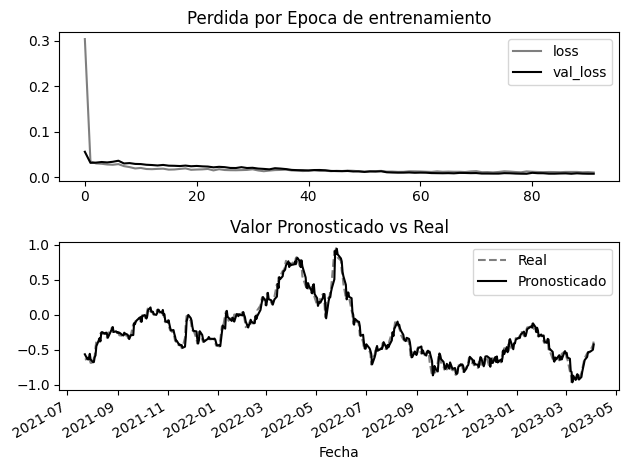

In [ ]:
plot_forecast(BCol_Optimizado, x_test_BCol, y_test_BCol, test_BCol.index, Historial_BCol)

Entrenamiento de la Red

In [ ]:
BCol_Optimizado.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
BCol_Optimizado.fit(x_train_BCol, y_train_BCol, batch_size = 32, epochs = 83)

Epoch 1/83
109/109 [==============================] - 6s 11ms/step - loss: 0.1568
Epoch 2/83
109/109 [==============================] - 1s 11ms/step - loss: 0.0225
Epoch 3/83
109/109 [==============================] - 1s 9ms/step - loss: 0.0212
Epoch 4/83
109/109 [==============================] - 1s 7ms/step - loss: 0.0195
Epoch 5/83
109/109 [==============================] - 1s 7ms/step - loss: 0.0184
Epoch 6/83
109/109 [==============================] - 1s 7ms/step - loss: 0.0173
Epoch 7/83
109/109 [==============================] - 1s 7ms/step - loss: 0.0174
Epoch 8/83
109/109 [==============================] - 1s 7ms/step - loss: 0.0173
Epoch 9/83
109/109 [==============================] - 1s 8ms/step - loss: 0.0171
Epoch 10/83
109/109 [==============================] - 1s 7ms/step - loss: 0.0167
Epoch 11/83
109/109 [==============================] - 1s 7ms/step - loss: 0.0162
Epoch 12/83
109/109 [==============================] - 1s 8ms/step - loss: 0.0163
Epoch 13/83
109/109 [==

Pronóstico

In [ ]:
prediccion_BCol = BCol_Optimizado.predict(x_test_BCol)
prediccion_BCol = BCol_estand.inverse_y(prediccion_BCol)

14/14 [==============================] - 2s 3ms/step


In [ ]:
prediccion_BCol_BMA = BCol_Optimizado.predict(x_test_BMA)
prediccion_BCol_BMA = BCol_estand.inverse_y(prediccion_BCol_BMA)

14/14 [==============================] - 1s 3ms/step


Grafica

<ipython-input-22-7106b0006212>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_BCol['Precio de Cierre Pronosticado'] = prediccion_BCol


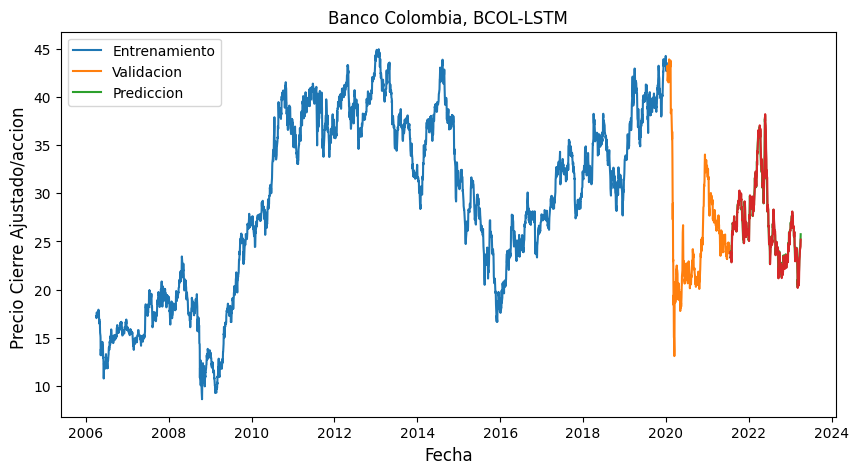

In [ ]:
train = BCol_os[:len(train_BCol)]
val = BCol_os[len(train_BCol):-len(test_BCol)]
test_BCol = BCol_os[-len(test_BCol):]
test_BCol['Precio de Cierre Pronosticado'] = prediccion_BCol

plt.figure(figsize=(10,5))
plt.title('Banco Colombia, BCOL-LSTM')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio Cierre Ajustado/accion ', fontsize=12)
plt.plot(train['Precio de Cierre Real'])
plt.plot(val['Precio de Cierre Real'])
plt.plot(test_BCol[['Precio de Cierre Real', 'Precio de Cierre Pronosticado']])
plt.legend(['Entrenamiento', 'Validacion', 'Prediccion'], loc='upper left')
plt.show()

Comparación de valores reales y pronosticados

In [ ]:
test_BCol.loc['2023-03-15':'2023-03-31', ['Precio de Cierre Real','Precio de Cierre Pronosticado']].round({'Precio de Cierre Real': 2, 'Precio de Cierre Pronosticado':1})

,Precio de Cierre Real,Precio de Cierre Pronosticado
Fecha,,
2023-03-15,21.06,21.100000
2023-03-16,20.54,20.900000
2023-03-17,20.85,20.400000
2023-03-20,21.54,20.700001
2023-03-21,22.02,21.400000
2023-03-22,22.56,21.900000
2023-03-23,23.11,22.400000
2023-03-24,23.54,23.000000
2023-03-27,24.16,23.400000


BMA con parametros optimizados

In [ ]:
#Se fijan los pesos de la red
seed = 7
tf.random.set_seed(seed)

In [ ]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, return_sequences=False,
                   input_shape=(train.shape[1],
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    return model

In [ ]:
def train_model_ts_adam(model,
                x_train, y_train, x_val, y_val,
                epochs=500,
                patience=12,
                batch_size=32):

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(),
                           MeanAbsolutePercentageError(),
                           MeanAbsoluteError()])

    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience)

    history = model.fit(x_train,y_train,
              shuffle=False, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [ ]:
BMA_os = one_step_forecast(BMA, 5)

In [ ]:
BMA_os.head(2)

,Precio a Dia 0,Precio a Dia 1,Precio a Dia 2,Precio a Dia 3,Precio a Dia 4,Precio de Cierre Real
Fecha,,,,,,
2006-03-31,14.162241,14.020185,14.576052,14.452523,14.014007,13.927539
2006-04-03,14.020185,14.576052,14.452523,14.014007,13.927539,13.649609


In [ ]:
BMA_os.rename(columns={"x_1": "Precio a Dia 0", "x_2": "Precio a Dia 1", "x_3": "Precio a Dia 2", "x_4": "Precio a Dia 3",
                       "x_5": "Precio a Dia 4", "y": "Precio de Cierre Real"}, inplace=True)

In [ ]:
BMA_estand = Standardize(BMA_os)

train_BMA, test_BMA, val_BMA = BMA_estand.fit_transform()

In [ ]:
def features_target_ts(*args):
    y = [col.pop('Precio de Cierre Real').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [ ]:
(y_train_BMA,
 y_val_BMA,
 y_test_BMA,
 x_train_BMA,
 x_val_BMA,
 x_test_BMA) = features_target_ts(train_BMA,
                               val_BMA,
                               test_BMA)

In [ ]:
BMA_Optimizado = create_model(train=x_train_BMA, units=32)

In [ ]:
Historial_BMA = train_model_ts_adam(BMA_Optimizado, x_train_BMA, y_train_BMA, x_val_BMA, y_val_BMA)

Epoch 1/500
109/109 [==============================] - 4s 12ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469 - mean_absolute_percentage_error: 153.7668 - mean_absolute_error: 0.3501 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1916 - val_mean_absolute_percentage_error: 26.5851 - val_mean_absolute_error: 0.1819
Epoch 2/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0364 - root_mean_squared_error: 0.1908 - mean_absolute_percentage_error: 56.5419 - mean_absolute_error: 0.1329 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502 - val_mean_absolute_percentage_error: 8.5916 - val_mean_absolute_error: 0.0386
Epoch 3/500
109/109 [==============================] - 1s 6ms/step - loss: 0.0271 - root_mean_squared_error: 0.1645 - mean_absolute_percentage_error: 48.6470 - mean_absolute_error: 0.1104 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618 - val_mean_absolute_percentage_error: 10.1403 - val_mean_absolute_error: 0.0522
Epoch 4/500
109/109 [===

14/14 [==============================] - 1s 3ms/step


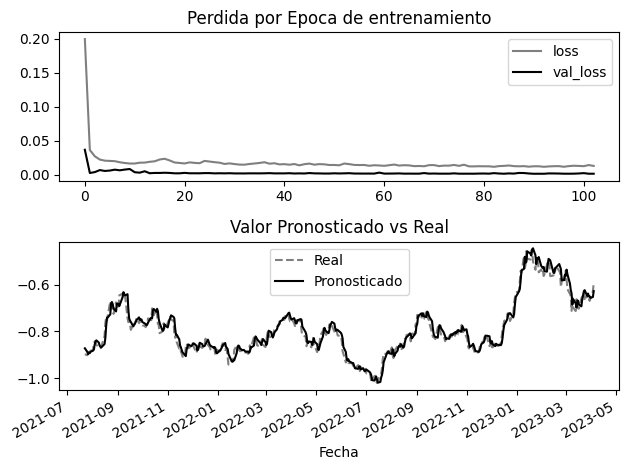

In [ ]:
plot_forecast(BMA_Optimizado, x_test_BMA, y_test_BMA, test_BMA.index, Historial_BMA)

In [ ]:
Metricas_Error_Modelos_optimizados = pd.DataFrame(np.array([BCol_Optimizado.evaluate(x=x_test_BCol, y=y_test_BCol), BMA_Optimizado.evaluate(x=x_test_BMA, y=y_test_BMA)]),
                              columns=['MSE', 'RMSE', 'MAPE', 'MAE'],
                      index=['BCol. Modelo Optimizado', 'BMA. Modelo Optimizado'])


14/14 [==============================] - 0s 3ms/step - loss: 5.5024e-04 - root_mean_squared_error: 0.0235 - mean_absolute_percentage_error: 2.4555 - mean_absolute_error: 0.0183


In [ ]:
Metricas_Error_Modelos_optimizados.loc[:, ['RMSE', 'MAPE', 'MAE']].sort_values('RMSE')

,RMSE,MAPE,MAE
BMA. Modelo Optimizado,0.023457,2.455478,0.018255
BCol. Modelo Optimizado,0.081058,123.933762,0.063362


Entrenamiento de la Red

In [ ]:
BMA_Optimizado.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
BMA_Optimizado.fit(x_train_BMA, y_train_BMA, batch_size = 32, epochs = 103)

Epoch 1/103
109/109 [==============================] - 3s 5ms/step - loss: 0.0119
Epoch 2/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0115
Epoch 3/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0123
Epoch 4/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0114
Epoch 5/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0127
Epoch 6/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0123
Epoch 7/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0125
Epoch 8/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0113
Epoch 9/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0121
Epoch 10/103
109/109 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 11/103
109/109 [==============================] - 1s 5ms/step - loss: 0.0123
Epoch 12/103
109/109 [==============================] - 1s 6ms/step - loss: 0.0119
Epoch 13/103


In [ ]:
prediccion_BMA = BMA_Optimizado.predict(x_test_BMA)
prediccion_BMA = BMA_estand.inverse_y(prediccion_BMA)

14/14 [==============================] - 0s 2ms/step


Gráfica

<ipython-input-64-e89928abc1c6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_BMA['Precio de Cierre Pronosticado'] = prediccion_BMA


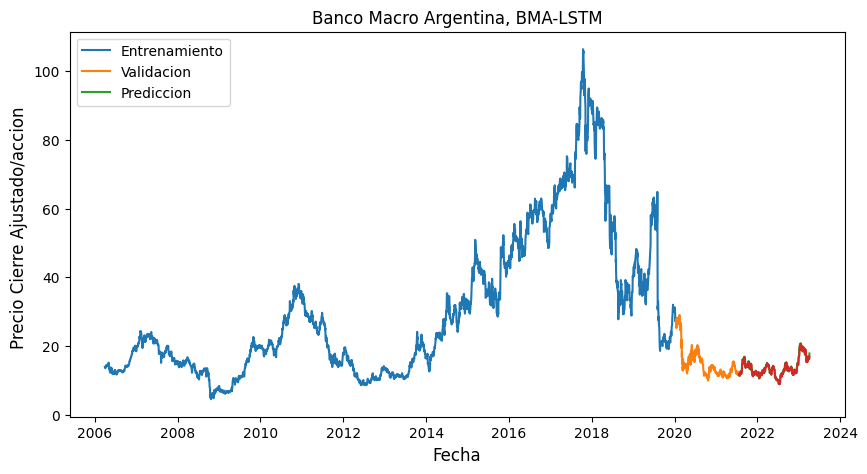

In [ ]:
train = BMA_os[:len(train_BMA)]
val = BMA_os[len(train_BMA):-len(test_BMA)]
test_BMA = BMA_os[-len(test_BMA):]
test_BMA['Precio de Cierre Pronosticado'] = prediccion_BMA

plt.figure(figsize=(10,5))
plt.title('Banco Macro Argentina, BMA-LSTM')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio Cierre Ajustado/accion ', fontsize=12)
plt.plot(train['Precio de Cierre Real'])
plt.plot(val['Precio de Cierre Real'])
plt.plot(test_BMA[['Precio de Cierre Real', 'Precio de Cierre Pronosticado']])
plt.legend(['Entrenamiento', 'Validacion', 'Valor Real', 'Valor Pronosticado'], loc='upper left')
plt.show()

Comparación de valores Reales y Pronosticados.

In [ ]:
test_BMA.loc['2023-03-15':'2023-03-31', ['Precio de Cierre Real','Precio de Cierre Pronosticado']].round(2)

,Precio de Cierre Real,Precio de Cierre Pronosticado
Fecha,,
2023-03-15,15.97,16.070000
2023-03-16,15.54,16.020000
2023-03-17,15.53,15.620000
2023-03-20,16.46,15.470000
2023-03-21,16.60,16.190001
2023-03-22,16.95,16.570000
2023-03-23,16.95,16.900000
2023-03-24,16.25,16.950001
2023-03-27,16.81,16.360001
